In [228]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')
import numpy as np

# **Reading file**

In [229]:
df = pd.read_csv('../data/Cancer_data.csv')

### **Type casting and cleaning**

In [230]:
df = df.drop('Unnamed: 32',axis=1)
df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0}).astype('int8')

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int8   
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

### **Checking for NaN**

In [232]:
df.isna().sum().mean()

0.0

### No duplicate ids

In [233]:
df.id.nunique(), df.shape[0]

(569, 569)

### **Features and target**

In [234]:
features = df.drop(['id','diagnosis'], axis=1)
target = df['diagnosis']

### **Classes Percentage**

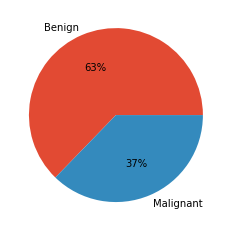

In [235]:
plt.pie(target.value_counts(), labels=['Benign', 'Malignant'], autopct='%.0f%%');

### **Removing outliers**

In [236]:
def drop_out_of_quantile(column):
    lower = column.quantile(.1)
    upper = column.quantile(.9)

    column = column.where((column < upper) & (column > lower))

    

In [237]:
for column_name in features:
    
    column = features[column_name]

    lower = column.quantile(.01)
    upper = column.quantile(.99)

    features[column_name] = column.where((column < upper) & (column > lower))

In [238]:
features = features.dropna()
target = target.iloc[features.index]

### **Removing low correlation features**

In [239]:
feat_corr = df.corr()[2:]['diagnosis']
top_features = feat_corr[(feat_corr > .1) | (feat_corr < -.1)]
top_features = features.loc[:, top_features.index]

In [240]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2)
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(features, target, test_size=.2)

### **Random Forest all features**

In [241]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate

rf = RandomForestClassifier(n_estimators=50,
                            max_depth=5,
                            random_state=2049,
                            class_weight='balanced')

rf.fit(X_train, y_train)

print(classification_report(y_pred=rf.predict(X_test), y_true=y_test))

cv_results = cross_validate(rf, X=features, y=target, cv=10,scoring='f1')
print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        55
           1       0.92      0.97      0.94        34

    accuracy                           0.96        89
   macro avg       0.95      0.96      0.95        89
weighted avg       0.96      0.96      0.96        89

10 Fold Cross validation mean f1 : 0.9497421798631477


### **Random Forest top features**

In [242]:
rf = RandomForestClassifier(n_estimators=50,
                            max_depth=5,
                            random_state=2049,
                            class_weight='balanced')

rf.fit(X_train_top, y_train_top)

print(classification_report(y_pred=rf.predict(X_test_top), y_true=y_test_top))
cv_results = cross_validate(rf, X=top_features, y=target, cv=10,scoring='f1')

print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        57
           1       0.85      0.91      0.88        32

    accuracy                           0.91        89
   macro avg       0.90      0.91      0.90        89
weighted avg       0.91      0.91      0.91        89

10 Fold Cross validation mean f1 : 0.9495711143695015


### **XGBoost all features**

In [243]:
from xgboost import XGBClassifier

scale_pos_weight = (target == False).sum()/(target == True).sum()
xgb = XGBClassifier(objective='binary:logistic',
                    scale_pos_weight=scale_pos_weight,
                    n_estimators=100)

xgb.fit(X_train_top, y_train_top)
print(classification_report(y_true=y_test, y_pred=rf.predict(X_test)))

cv_results = cross_validate(xgb, X=features, y=target, cv=10,scoring='f1')
print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        55
           1       0.97      1.00      0.99        34

    accuracy                           0.99        89
   macro avg       0.99      0.99      0.99        89
weighted avg       0.99      0.99      0.99        89

10 Fold Cross validation mean f1 : 0.9741739980449658


### **XGBoost top features**

In [244]:
xgb = XGBClassifier(objective='binary:logistic',
                    scale_pos_weight=scale_pos_weight,
                    n_estimators=100)

xgb.fit(X_train_top, y_train_top)
print(classification_report(y_true=y_test_top, y_pred=rf.predict(X_test_top)))

cv_results = cross_validate(xgb, X=top_features, y=target, cv=10,scoring='f1')
print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        57
           1       0.85      0.91      0.88        32

    accuracy                           0.91        89
   macro avg       0.90      0.91      0.90        89
weighted avg       0.91      0.91      0.91        89

10 Fold Cross validation mean f1 : 0.9745906647116325


### **Grid Search**

In [245]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": [20, 60, 100],
    "max_depth": [ 2, 5],
    "max_leaves":[0, 2, 5],
    "learning_rate":[.1, .01, .5],
    "verbosity": [1],
    "objective": ['binary:logistic'],
    "n_jobs": [-1],
    "scale_pos_weight": [None, scale_pos_weight, np.sqrt(scale_pos_weight)]
}
grid = GridSearchCV(XGBClassifier(), 
                    param_grid=params,
                    cv=10, 
                    scoring='f1')


In [246]:
grid.fit(X_train_top, y_train_top)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                         

In [247]:
best_xgb = XGBClassifier(**grid.best_params_)

In [248]:
cv_results = cross_validate(best_xgb, X=top_features, y=target, cv=10,scoring='f1')
print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')

10 Fold Cross validation mean f1 : 0.9743890518084068


### **LightGBM all features**

In [249]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(class_weight='balanced')

lgb.fit(X_train, y_train)

print(classification_report(y_true=y_test, y_pred=rf.predict(X_test)))

cv_results = cross_validate(lgb, X=features, y=target, cv=10,scoring='f1')
print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        55
           1       0.97      1.00      0.99        34

    accuracy                           0.99        89
   macro avg       0.99      0.99      0.99        89
weighted avg       0.99      0.99      0.99        89

10 Fold Cross validation mean f1 : 0.970733137829912


In [250]:
lgb.fit(X_train_top, y_train_top)

print(classification_report(y_true=y_test_top, y_pred=rf.predict(X_test_top)))

cv_results = cross_validate(lgb, X=top_features, y=target, cv=10,scoring='f1')
print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        57
           1       0.85      0.91      0.88        32

    accuracy                           0.91        89
   macro avg       0.90      0.91      0.90        89
weighted avg       0.91      0.91      0.91        89

10 Fold Cross validation mean f1 : 0.9741665823979506
